In [67]:
import pandas as pd

In [68]:
df=pd.read_csv('Housing.csv')
df.sample()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
249,4543000,4990,4,2,2,yes,yes,yes,no,no,0,yes,furnished


In [69]:
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))

df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)
df.sample(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
95,6300000,4100,3,2,3,1,0,0,0,1,2,0,True,False
168,5250000,4260,4,1,2,1,0,1,0,1,0,0,False,False
15,9100000,6000,4,1,2,1,0,1,0,0,2,0,True,False
245,4550000,5360,3,1,2,1,0,0,0,0,2,1,False,True
187,5110000,6100,3,1,1,1,0,1,0,1,0,1,True,False


In [70]:
binary_cols = ['furnishingstatus_semi-furnished','furnishingstatus_unfurnished']
df[binary_cols] = df[binary_cols].astype(int)
df.sample(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
482,2940000,3150,3,1,2,0,0,0,0,0,0,0,0,1
65,6930000,8880,3,2,2,1,0,1,0,1,1,0,0,0
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
481,2940000,2700,2,1,1,0,0,0,0,0,0,0,0,0
23,8645000,4560,3,2,2,1,1,1,0,1,1,0,0,0


In [71]:
df1=pd.read_csv('advertising.csv')
df1.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


<h3>Eigen vector and eigenvalues</h3>

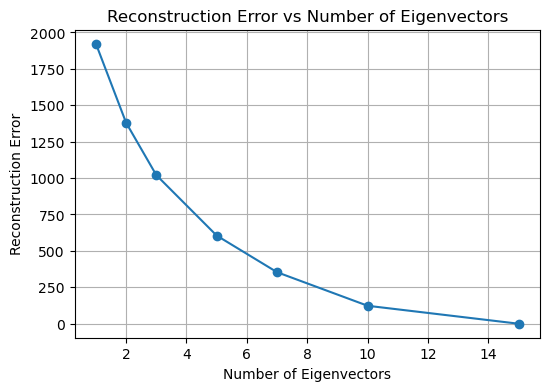

[1922.4216596944862,
 1379.9049645010728,
 1020.3790685488309,
 605.2114787685317,
 353.625614674139,
 123.2121931459352,
 1.2490841575721508e-22]

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def eigenface_reconstruction_error(X, n_values=[1, 2, 3, 5, 7, 10,15]):
    X = np.array(X, dtype=float)
    #print(X)
    
    #  Mean centering
    mean = np.mean(X, axis=0)
    A = X - mean
    
    # Covariance matrix trick (A^T A)
    ATA = np.dot(A.T, A)
    eigvals, eigvecs = np.linalg.eigh(ATA)
    #print(eigvals)
    #print(eigvecs)
    
    # Sort eigenvalues/vectors in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    #print(eigvals)
    errors = []
    
    for n in n_values:
        top_eigvecs = eigvecs[:, :n] 
        
        
        W = np.dot(A, top_eigvecs) # Projection (weights)
        
        # Reconstruction
        L = np.dot(W, top_eigvecs.T)
        R = L + mean
        
        # Reconstruction error
        error = np.sum((X - R) ** 2)
        errors.append(error)
    
    # Step 6: Plot
    plt.figure(figsize=(6, 4))
    plt.plot(n_values, errors, marker='o')
    plt.xlabel('Number of Eigenvectors')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error vs Number of Eigenvectors')
    plt.grid(True)
    plt.show()
    
    return errors

X = df.drop('price', axis=1)
eigenface_reconstruction_error(X)


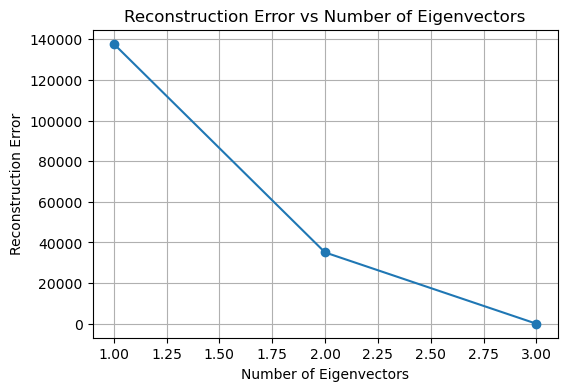

[137786.12440737645, 35086.87584251772, 4.596904809239905e-25]

In [73]:
X = df1.drop('Sales', axis=1)
eigenface_reconstruction_error(X,[1,2,3])


<h3>Gradient Descent</h3>

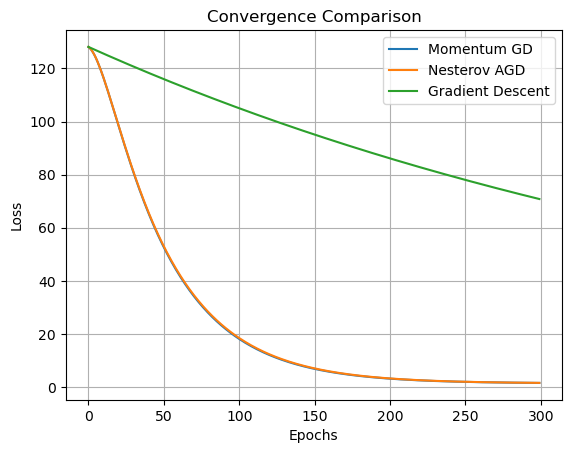

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def compute_loss(X, y, w):
    n = len(y)
    y_pred = X @ w
    return (1/(2*n)) * np.sum((y_pred - y) ** 2)

# Gradient
def compute_grad(X, y, w):
    n = len(y)
    y_pred = X @ w
    return (1/n) * (X.T @ (y_pred - y))

def gradient_descent(X, y, lr=0.01, epochs=100):
    w = np.zeros(X.shape[1])
    losses = []
    for _ in range(epochs):
        grad = compute_grad(X, y, w)
        w -= lr * grad
        losses.append(compute_loss(X, y, w))
    return w, losses

def momentum_gd(X, y, lr=0.01, gamma=0.9, epochs=100):
    w = np.zeros(X.shape[1],dtype=float)
    v = np.zeros_like(w)
    losses = []
    for _ in range(epochs):
        grad = compute_grad(X, y, w)
        v = gamma * v + lr * grad
        w -= v
        losses.append(compute_loss(X, y, w))
    return w, losses

def nesterov_gd(X, y, lr=0.01, gamma=0.9, epochs=100):
    w = np.zeros(X.shape[1])
    v = np.zeros_like(w)
    losses = []
    for _ in range(epochs):
        grad = compute_grad(X, y, w - gamma * v)   # lookahead
        v = gamma * v + lr * grad
        w -= v
        losses.append(compute_loss(X, y, w))
    return w, losses

#X =  df.drop('price', axis=1).values
#y = df['price'].values

X = df1.drop('Sales', axis=1).values
y = df1['Sales'].values

#NOTE: when we havent standaradized, loss was increasing with no. of epochs
# Standardize features (exclude bias column)
X_mean = X.mean(axis=0)
X_std  = X.std(axis=0) 
X = (X - X_mean) / X_std

# Add bias term
X = np.c_[np.ones(X.shape[0]), X]

# Train using the 3 methods
w_gd, loss_gd = gradient_descent(X, y, lr=0.001,  epochs=300)
w_mgd, loss_mgd = momentum_gd(X, y, lr=0.001, gamma=0.9, epochs=300)
w_nag, loss_nag = nesterov_gd(X, y, lr=0.001, gamma=0.9, epochs=300)

#print(loss_nag)
plt.plot(loss_mgd, label="Momentum GD",)
plt.plot(loss_nag, label="Nesterov AGD")
plt.plot(loss_gd, label="Gradient Descent")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergence Comparison")
plt.grid()
plt.show()


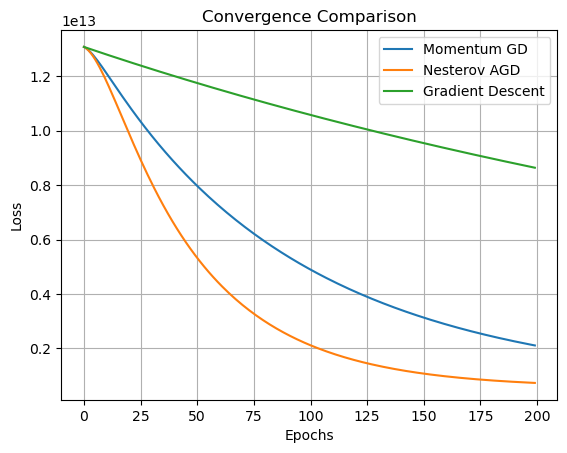

In [75]:

X =  df.drop('price', axis=1).values
y = df['price'].values

#NOTE: when we havent standaradized, loss was increasing with no. of epochs
# Standardize features (exclude bias column)
X_mean = X.mean(axis=0)
X_std  = X.std(axis=0) 
X = (X - X_mean) / X_std

# Add bias term
X = np.c_[np.ones(X.shape[0]), X]

# Train using the 3 methods
w_gd, loss_gd = gradient_descent(X, y, lr=0.001,  epochs=200)
w_mgd, loss_mgd = momentum_gd(X, y, lr=0.001, gamma=0.8, epochs=200)
w_nag, loss_nag = nesterov_gd(X, y, lr=0.001, gamma=0.9, epochs=200)

#print(loss_nag)
plt.plot(loss_mgd, label="Momentum GD",)
plt.plot(loss_nag, label="Nesterov AGD")
plt.plot(loss_gd, label="Gradient Descent")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergence Comparison")
plt.grid()
plt.show()
